In [1]:
import odl
import numpy as np
import matplotlib.pyplot as plt
import importlib
import utils as ut

## Test on 2D Phantom

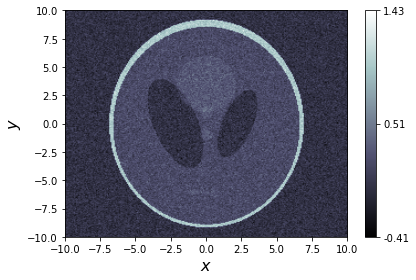

<Figure size 432x288 with 0 Axes>

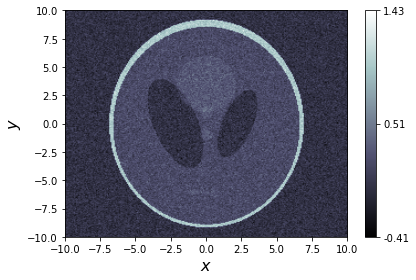

In [2]:
# Define ground truth, space and noisy data
n = 256
xlim = 10
space = odl.uniform_discr(min_pt=[-xlim]*2, max_pt=[xlim]*2, shape=(n, n))
orig = odl.phantom.shepp_logan(space, modified=True)
d = odl.phantom.white_noise(space, orig, 0.1)
d.show()

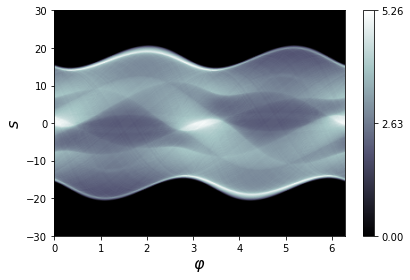

<Figure size 432x288 with 0 Axes>

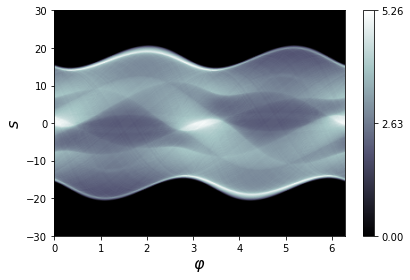

In [3]:
apart = odl.uniform_partition(0, 2*np.pi, n) # angular partition
dpart = odl.uniform_partition(-3*xlim, 3*xlim, n) # detector partition how big is the wall
geometry = odl.tomo.FanBeamGeometry(apart=apart, dpart=dpart, src_radius=2*xlim, det_radius=2*xlim)
ray_trafo = odl.tomo.RayTransform(space, geometry, impl="astra_cuda")
g = ray_trafo(orig)
g.show()

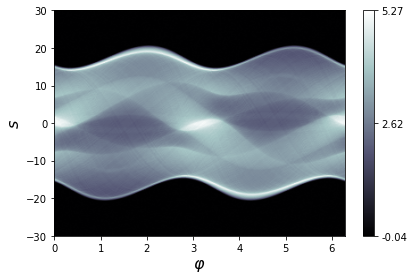

<Figure size 432x288 with 0 Axes>

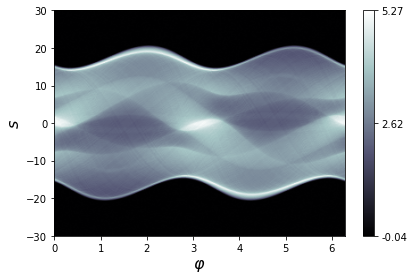

In [4]:
g_noisy = g + 0.01 * odl.phantom.white_noise(ray_trafo.range)
g_noisy.show()

In [37]:
error = []
def save_error(f):
    error.append((orig-f).norm())
callback = (odl.solvers.CallbackPrintIteration(step=10) & 
        odl.solvers.CallbackShow(step=10) &
        save_error)

iter = 0


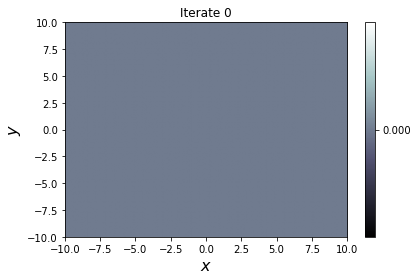

<Figure size 432x288 with 0 Axes>

iter = 10


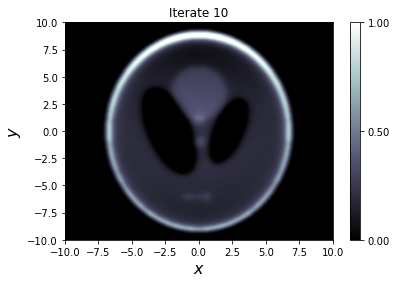

<Figure size 432x288 with 0 Axes>

iter = 20


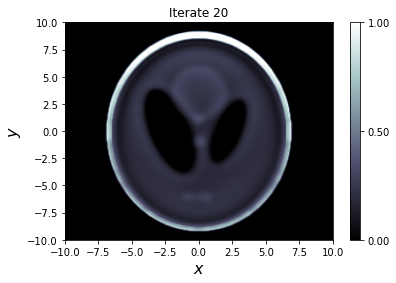

<Figure size 432x288 with 0 Axes>

iter = 30


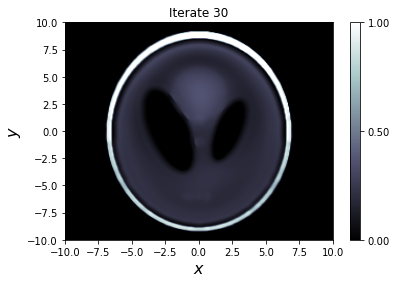

<Figure size 432x288 with 0 Axes>

iter = 40


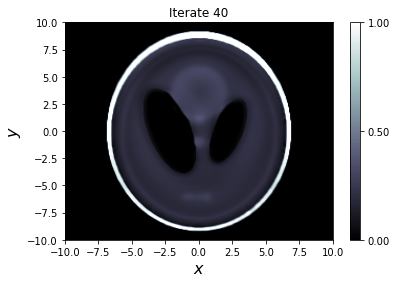

<Figure size 432x288 with 0 Axes>

iter = 50


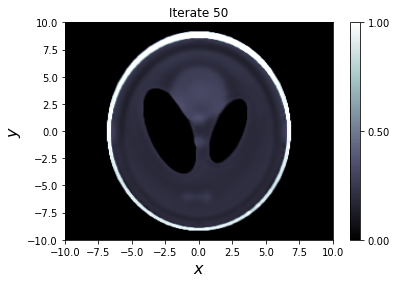

<Figure size 432x288 with 0 Axes>

iter = 60


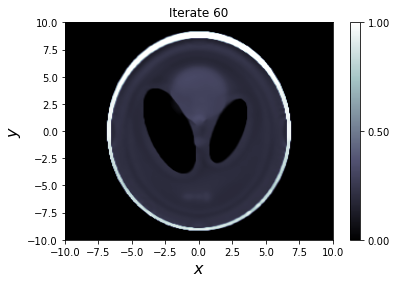

<Figure size 432x288 with 0 Axes>

iter = 70


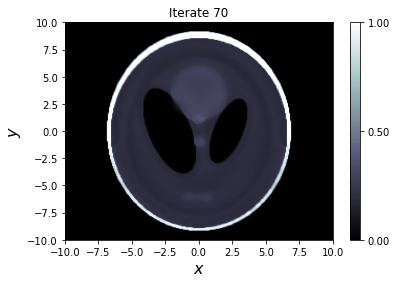

<Figure size 432x288 with 0 Axes>

iter = 80


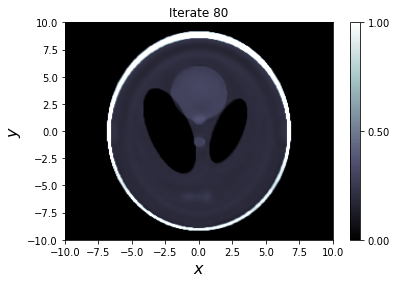

<Figure size 432x288 with 0 Axes>

iter = 90


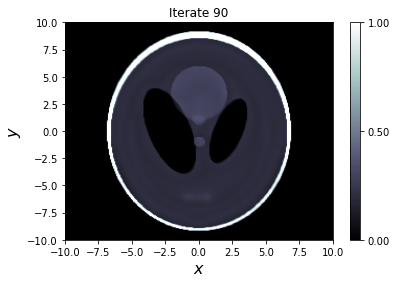

<Figure size 432x288 with 0 Axes>

In [6]:
# Assemble all operators into a list 
grad = odl.Gradient(space)

lin_ops = [ray_trafo, grad]
_lambda = 0.01
_gamma = 0.01

# Create functionals for the l2 distance and huber norm
g_funcs = [odl.solvers.L2NormSquared(ray_trafo.range).translated(g_noisy), 
          _lambda * odl.solvers.Huber(grad.range, gamma=_gamma)]

#Functional of the bound contraint 0 <= x <= 1
f = odl.solvers.IndicatorBox(space, 0, 1)

# Find scaling constants so that the solver converges.
opnorm_ray_trafo = odl.power_method_opnorm(ray_trafo, xstart=g_noisy)
opnorm_grad = odl.power_method_opnorm(grad, xstart=g_noisy)
sigma = [1 / opnorm_ray_trafo ** 2, 1 / opnorm_grad ** 2]
tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
x = ray_trafo.domain.zero()

odl.solvers.douglas_rachford_pd(x, f, g_funcs, lin_ops, tau=tau, sigma = sigma, niter=100, callback=callback)

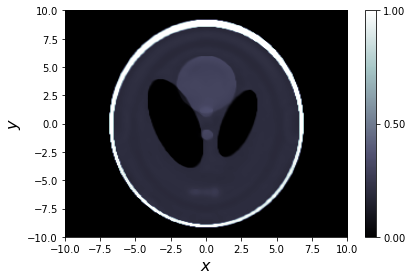

<Figure size 432x288 with 0 Axes>

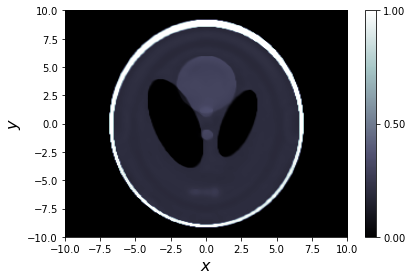

In [7]:
x.show()

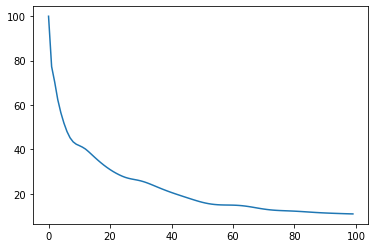

In [8]:
rel_error = np.array(error)/orig.norm() * 100
plt.plot(rel_error)

iter = 0


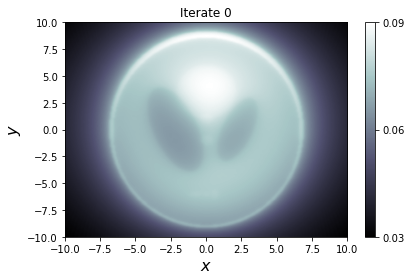

<Figure size 432x288 with 0 Axes>

iter = 10


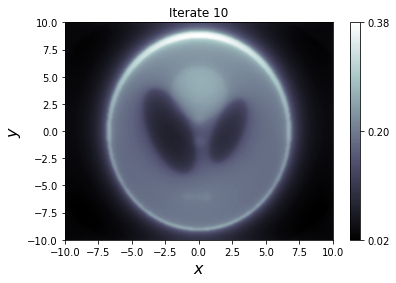

<Figure size 432x288 with 0 Axes>

iter = 20


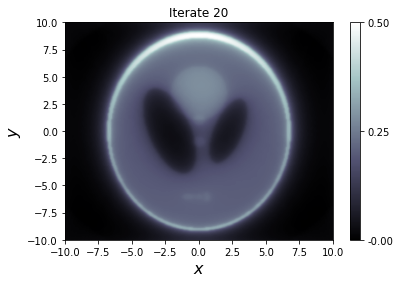

<Figure size 432x288 with 0 Axes>

iter = 30


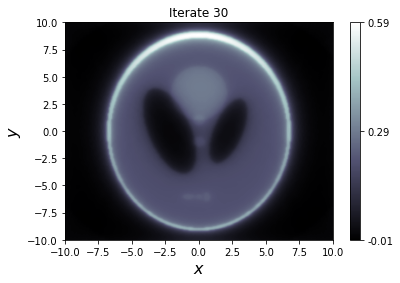

<Figure size 432x288 with 0 Axes>

iter = 40


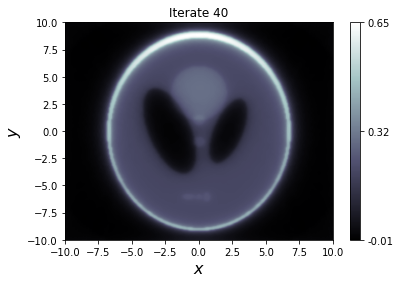

<Figure size 432x288 with 0 Axes>

iter = 50


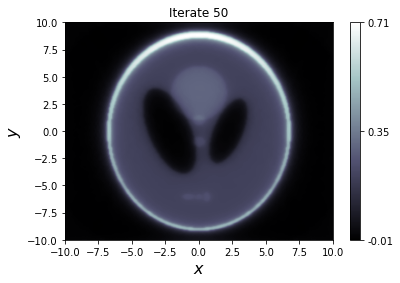

<Figure size 432x288 with 0 Axes>

iter = 60


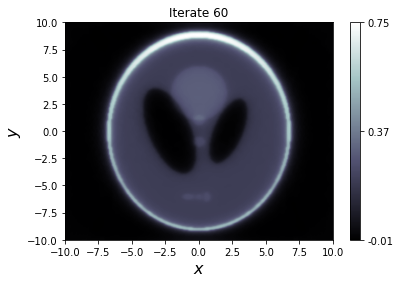

<Figure size 432x288 with 0 Axes>

iter = 70


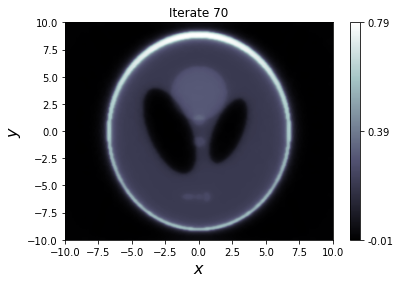

<Figure size 432x288 with 0 Axes>

iter = 80


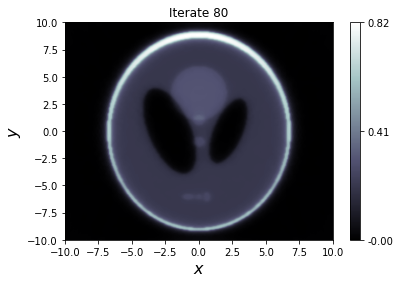

<Figure size 432x288 with 0 Axes>

iter = 90


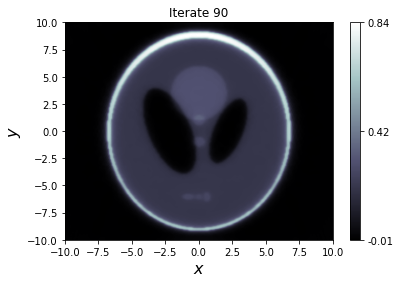

<Figure size 432x288 with 0 Axes>

iter = 100


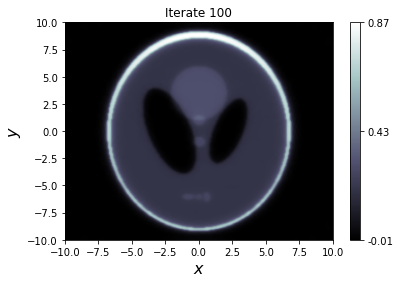

<Figure size 432x288 with 0 Axes>

iter = 110


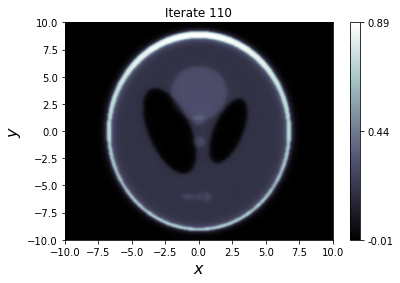

<Figure size 432x288 with 0 Axes>

iter = 120


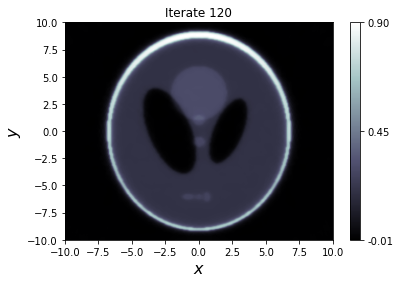

<Figure size 432x288 with 0 Axes>

iter = 130


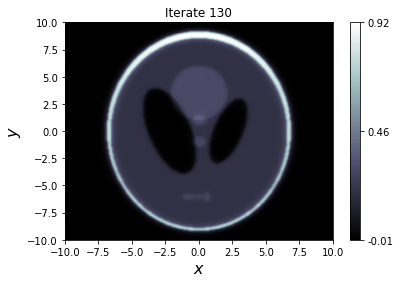

<Figure size 432x288 with 0 Axes>

iter = 140


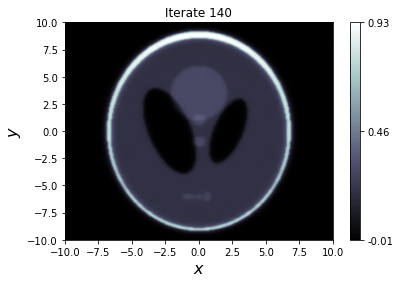

<Figure size 432x288 with 0 Axes>

iter = 150


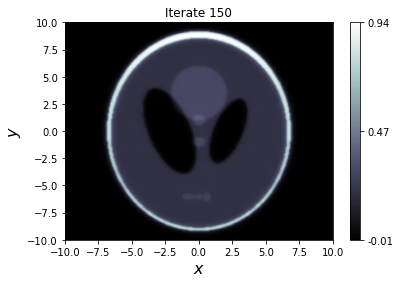

<Figure size 432x288 with 0 Axes>

iter = 160


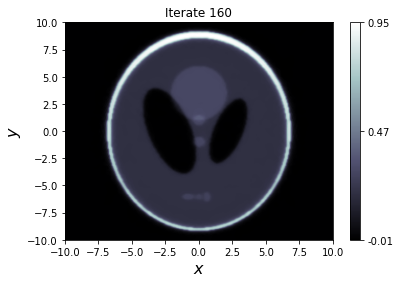

<Figure size 432x288 with 0 Axes>

iter = 170


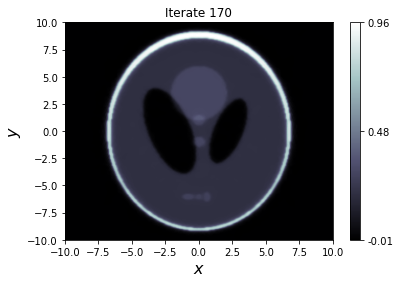

<Figure size 432x288 with 0 Axes>

iter = 180


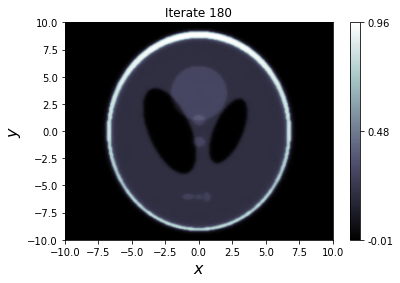

<Figure size 432x288 with 0 Axes>

iter = 190


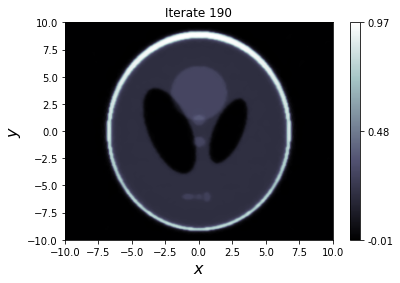

<Figure size 432x288 with 0 Axes>

iter = 200


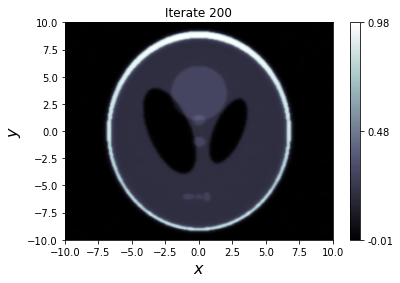

<Figure size 432x288 with 0 Axes>

iter = 210


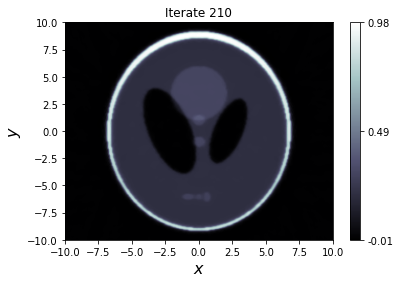

<Figure size 432x288 with 0 Axes>

iter = 220


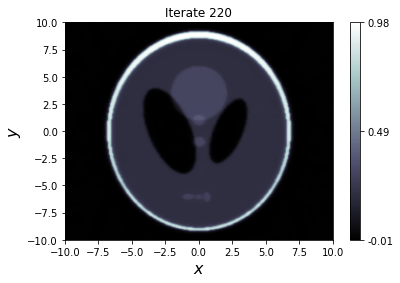

<Figure size 432x288 with 0 Axes>

iter = 230


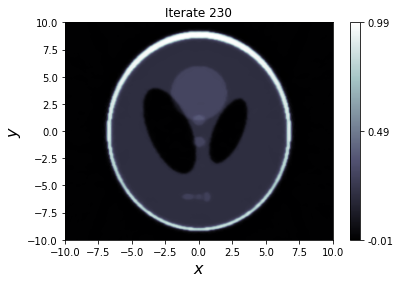

<Figure size 432x288 with 0 Axes>

iter = 240


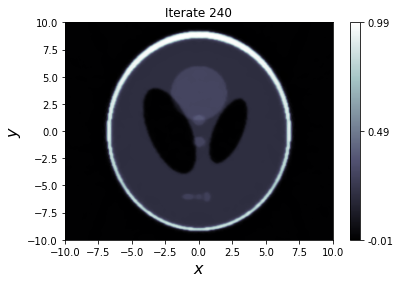

<Figure size 432x288 with 0 Axes>

iter = 250


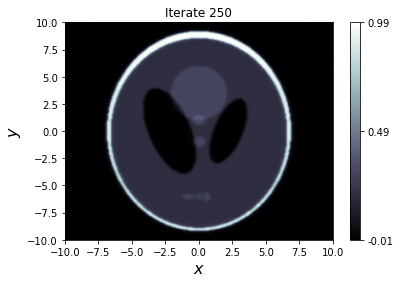

<Figure size 432x288 with 0 Axes>

iter = 260


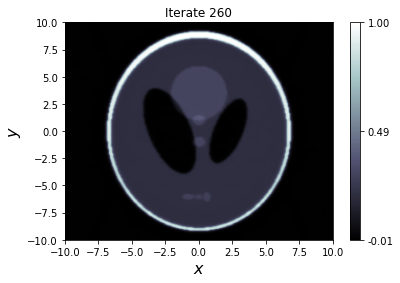

<Figure size 432x288 with 0 Axes>

iter = 270


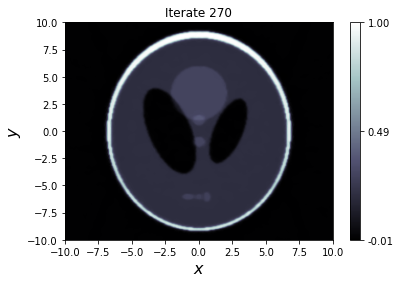

<Figure size 432x288 with 0 Axes>

iter = 280


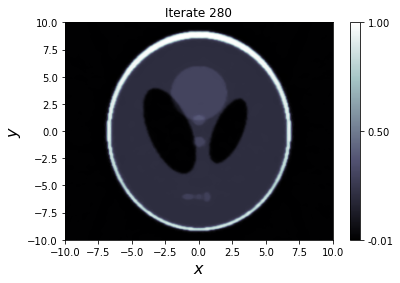

<Figure size 432x288 with 0 Axes>

iter = 290


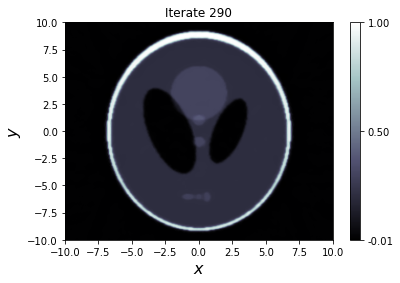

<Figure size 432x288 with 0 Axes>

In [38]:
error = []
def save_error(f):
    error.append((orig-f).norm())
    
grad = odl.Gradient(space)
huber_solver = odl.solvers.Huber(grad.range, gamma=_gamma) #small gamma

Q = odl.solvers.L2NormSquared(ray_trafo.range).translated(g_noisy) * ray_trafo + _lambda * huber_solver * grad

callback = (odl.solvers.CallbackPrintIteration(step=10) & odl.solvers.CallbackShow(step=10) & save_error)
x_s_d = ray_trafo.domain.zero()
odl.solvers.smooth.gradient.steepest_descent(Q, x_s_d, line_search=0.001, maxiter=300, callback=callback)

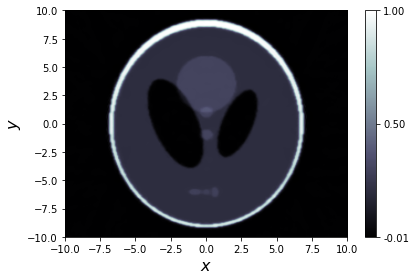

<Figure size 432x288 with 0 Axes>

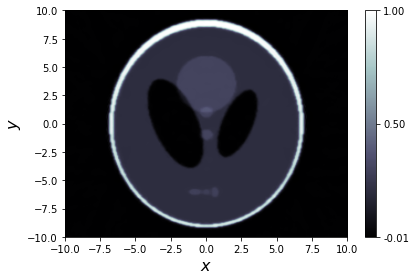

In [39]:
x_s_d.show()

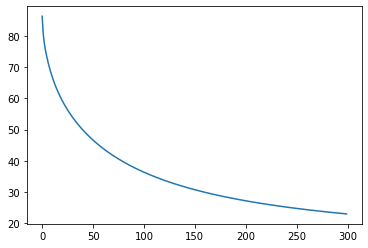

In [40]:
rel_error = np.array(error)/orig.norm() * 100
plt.plot(rel_error)